In [24]:
import argparse, os, sys, glob, datetime, yaml, random, re, time, torch, cv2, warnings
current_dir = os.getcwd()
os.chdir(os.path.dirname(current_dir))
import numpy as np
from tqdm import trange
import pandas as pd
from omegaconf import OmegaConf
from PIL import Image
import matplotlib.pyplot as plt
from einops import rearrange
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.util import instantiate_from_config
from ldm.data.pubchemdata import pubchemBase_single_protein
from scripts.sample_diffusion_condition_single_protein import run as sample_ep4_mol
from scripts.inpaint_target import make_batch, extract_values, get_parser, load_model
from scripts.inpaint_target import run as sample_ep4_mol_fragment
warnings.filterwarnings("ignore")

This tutorial includes two tasks: EP4 de novo design and fragment growing.

Note that you should use a GPU with at least 24GB to run this tutorial.

Basic parameters for sampling EP4 molecules. 

In [70]:
now = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
args_list = [
    '--resume', '/work/data1/wangzixu/backup/sketchmol_model/ep4/last.ckpt',  # path to yout ckpt
    '--post', '_exmaple_tutorial',  #The suffix of the folder where the results are saved.
    '--conditional_count', '4',  # generate 4 molecular images
    '--scale_pro', '2',          # The degree to which the generation is oriented towards properties.
    '--preset_str', 'EP4:1',
    '--validation_dataset', './scripts/inpainting_csv/example_fragment_grow.csv',
]
parser = get_parser()
opt, unknown = parser.parse_known_args(args_list)
if not os.path.exists(opt.resume):
    raise ValueError("Cannot find {}".format(opt.resume))

logdir = '/'.join(opt.resume.split('/')[:-1])
ckpt = opt.resume

yaml_file = glob.glob(os.path.join(logdir, "*.yaml"))
opt.base = yaml_file

configs = [OmegaConf.load(cfg) for cfg in opt.base]
cli = OmegaConf.from_dotlist(unknown)
config = OmegaConf.merge(*configs, cli)

gpu = True
eval_mode = True

logdir = os.path.join(logdir, now + opt.post, "samples")
imglogdir = os.path.join(logdir, "img")
os.makedirs(imglogdir, exist_ok=True)

Code for storing/loading configuration files and models, etc.

In [27]:
model, _ = load_model(config, ckpt, gpu, eval_mode)
sampling_file = os.path.join(logdir, "sampling_config.yaml")
sampling_conf = vars(opt)
with open(sampling_file, 'w') as f:
    yaml.dump(sampling_conf, f, default_flow_style=False)
print("Images will be saved to", logdir)
print(75 * "=")

Loading model from /work/data1/wangzixu/backup/sketchmol_model/ep4/last.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 846.74 M params.
Keeping EMAs of 688.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
prepare protein embedder
Images will be saved to /work/data1/wangzixu/backup/sketchmol_model/ep4/2024-10-16-14-30-23_exmaple_tutorial/samples


## For sampling EP4 molecular images 

In [71]:
sample_ep4_mol(model, imglogdir=imglogdir, eta=opt.eta, scale=opt.scale, logdir=logdir,
    vanilla=opt.vanilla_sample, n_samples=opt.n_samples, custom_steps=opt.custom_steps,
    conditional_count=opt.conditional_count,
    condition_type=opt.condition_type, 
    preset_str=opt.preset_str, tri_mode=opt.tri, scale_pro=opt.scale_pro)

Using DDIM sampling with 250 sampling steps and eta=1.0
valid_scale:2.0 property_scale:2.0
Your Sample condition is :
LogP:None
QED:None
MW:None
TPSA:None
HBD:None
HBA:None
RB:None
EP4:1.0
AKT1:None
ROCK1:None
Running conditional sampling for 1 samples
each condition have 4 samples
so finally, output image is 4


Sampling Batches (conditional):   0%|                                             | 0/1 [00:00<?, ?it/s]

Data shape for DDIM sampling is (4, 4, 32, 32), eta 1.0
Running DDIM Sampling with 250 timesteps



DDIM Sampler:  30%|███████████████▍                                    | 74/250 [00:18<00:44,  3.92it/s]


DDIM Sampler:  60%|██████████████████████████████▍                    | 149/250 [00:38<00:25,  3.90it/s]


DDIM Sampler:  90%|█████████████████████████████████████████████▋     | 224/250 [00:57<00:06,  3.91it/s]


Sampling Batches (conditional): 100%|█████████████████████████████████████| 1/1 [01:04<00:00, 64.30s/it]

path save to /work/data1/wangzixu/backup/sketchmol_model/ep4/2024-10-16-15-36-25_exmaple_tutorial/samples/image_path.csv
done.


print these generated images 

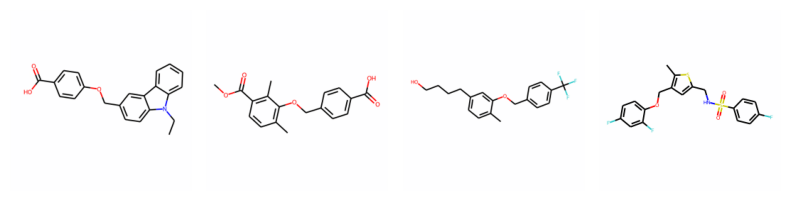

In [73]:
generated_csv_file = "path to your generated images"
df = pd.read_csv(generated_csv_file)
image_paths = df['image_path'].tolist() 
num_images = len(image_paths)
images_per_row = 4
num_rows = (num_images + images_per_row - 1) // images_per_row

fig, axes = plt.subplots(num_rows, images_per_row, figsize=(images_per_row * 2, num_rows * 4))
axes = axes.flatten()  

for i, image_path in enumerate(image_paths):
    img = Image.open(image_path)
    axes[i].imshow(img)
    axes[i].axis('off') 
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()

## For EP4 fragment growing

 You need to input a CSV file (--validation_dataset your_inpainting.csv). The Path column stores the molecules to be processed, and the "Path_keep" column stores the fragment region you want to retain (sketchmol will mask other areas).

In this example, we first prepare a starting molecule.

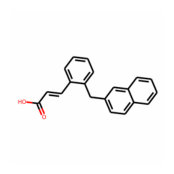

In [39]:
example_df = pd.read_csv(opt.validation_dataset)
start_molecule_image_path = example_df['Path'].iloc[0]
img = Image.open(start_molecule_image_path)
plt.figure(figsize=(2,2))
plt.imshow(img)
plt.axis('off') 
plt.show()

At the same time, you need to prepare the fragment you want to save as the starting point for generation.

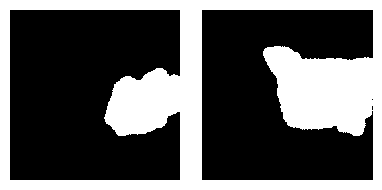

In [42]:
fragment_paths = example_df['Path_keep'].tolist() 
num_images = len(fragment_paths)
images_per_row = 2
num_rows = (num_images + images_per_row - 1) // images_per_row

fig, axes = plt.subplots(num_rows, images_per_row, figsize=(2 * images_per_row, 2 * num_rows)) 
axes = axes.flatten()  

for i, fragment_path in enumerate(fragment_paths):
    img = Image.open(fragment_path)
    axes[i].imshow(img, cmap='gray', interpolation='none')  
    axes[i].axis('off')  
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()

During the generation process, SketchMol can recognize the retained region and fill in the remaining areas. 

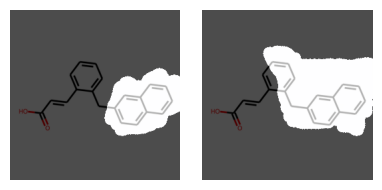

In [48]:
original_paths = example_df['Path'].tolist()  
mask_paths = example_df['Path_keep'].tolist()  

num_images = len(original_paths)
images_per_row = 2

num_rows = (num_images + images_per_row - 1) // images_per_row

fig, axes = plt.subplots(num_rows, images_per_row, figsize=(2 * images_per_row, num_rows * 2))
axes = axes.flatten()

for i, (original_path, mask_path) in enumerate(zip(original_paths, mask_paths)):
    img = Image.open(original_path).convert("RGBA")
    mask = Image.open(mask_path).convert("RGBA")
    
    blended_mask = Image.blend(img, mask, alpha=0.7)
    
    axes[i].imshow(blended_mask)
    axes[i].axis('off') 

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Let's try generating a batch of molecules based on the preselected fragment.

In [64]:
sample_ep4_mol_fragment(model, 
                        imglogdir=imglogdir, 
                        eta=opt.eta, scale=opt.scale, logdir=logdir,
                        vanilla=opt.vanilla_sample, n_samples=opt.n_samples, custom_steps=opt.custom_steps,
                        conditional_count=opt.conditional_count,
                        condition_type=opt.condition_type, 
                        preset_str=opt.preset_str, tri_mode=opt.tri, scale_pro=opt.scale_pro,
                        validation_dataset=opt.validation_dataset, mask_from_where=opt.mask_from_where,
                        zoom_factor=opt.zoom_factor, repaint_time=opt.repaint_time,)

valid_scale:2.0 property_scale:2.0
Your Sample condition is :
LogP:None
QED:None
MW:None
TPSA:None
HBD:None
HBA:None
RB:None
EP4:1.0
AKT1:None
ROCK1:None
each condition have 4 samples
read from ./scripts/inpainting_csv/example_fragment_grow.csv


Sampling Batches (conditional):   0%|                                             | 0/2 [00:00<?, ?it/s]

Data shape for DDIM sampling is (4, 4, 32, 32), eta 1.0
Running DDIM Sampling with 250 timesteps
Running repaint with 1 timesteps



DDIM Sampler:  30%|███████████████▍                                    | 74/250 [00:37<01:29,  1.97it/s]


DDIM Sampler:  60%|██████████████████████████████▍                    | 149/250 [01:15<00:51,  1.96it/s]


DDIM Sampler:  90%|█████████████████████████████████████████████▋     | 224/250 [01:53<00:13,  1.96it/s]


Sampling Batches (conditional):  50%|██████████████████                  | 1/2 [02:07<02:07, 127.71s/it]

Data shape for DDIM sampling is (4, 4, 32, 32), eta 1.0
Running DDIM Sampling with 250 timesteps
Running repaint with 1 timesteps



DDIM Sampler:  30%|███████████████▍                                    | 74/250 [00:37<01:29,  1.96it/s]


DDIM Sampler:  60%|██████████████████████████████▍                    | 149/250 [01:15<00:51,  1.96it/s]


DDIM Sampler:  90%|█████████████████████████████████████████████▋     | 224/250 [01:54<00:13,  1.96it/s]


Sampling Batches (conditional): 100%|████████████████████████████████████| 2/2 [04:15<00:00, 127.90s/it]

path save to /work/data1/wangzixu/backup/sketchmol_model/ep4/2024-10-16-15-26-50_exmaple_tutorial/samples/image_path.csv
done.
sampling of 8 images finished in 4.26 minutes.


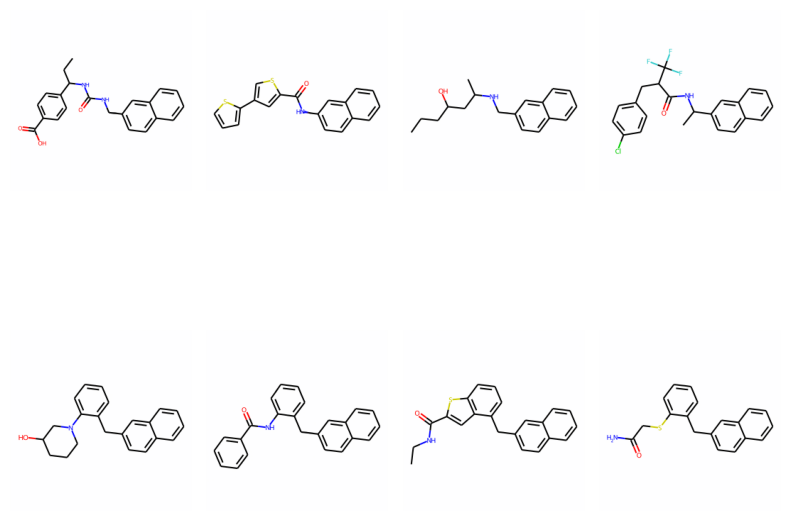

In [66]:
generated_csv_file = "path to your generated images"
df = pd.read_csv(generated_csv_file)
image_paths = df['image_path'].tolist() 
num_images = len(image_paths)
images_per_row = 4
num_rows = (num_images + images_per_row - 1) // images_per_row

fig, axes = plt.subplots(num_rows, images_per_row, figsize=(images_per_row * 2, num_rows * 4))
axes = axes.flatten()  

for i, image_path in enumerate(image_paths):
    img = Image.open(image_path)
    axes[i].imshow(img)
    axes[i].axis('off') 
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()